# Score-matching informed KDE

In [ ]:
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
import lib.toy_data as toy_data
import numpy as np
import argparse
import pandas as pd
from pandas.plotting import scatter_matrix as pdsm
import functions_WPO_SGM as LearnCholesky
# git testing

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ["CUDA_VISIBLE_DEVICES"]="1"

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')
    print("GPU is not available")
print(device)

GPU is not available
cpu


### Parsing for scripts

In [3]:
parser = argparse.ArgumentParser(' ')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings','swissroll_6D_xy1', 'cifar10'], type = str,default = '2spirals')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 5)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 64)
parser.add_argument('--niters',type = int, default = 5000)
parser.add_argument('--batch_size', type = int,default = 5)
parser.add_argument('--lr',type = float, default = 2e-3) 
parser.add_argument('--save',type = str,default = 'experiments/')
parser.add_argument('--train_kernel_size',type = int, default = 100)
parser.add_argument('--train_samples_size',type = int, default = 500)
parser.add_argument('--test_samples_size',type = int, default = 5)
args = parser.parse_args('')

In [4]:
train_kernel_size = args.train_kernel_size
train_samples_size = args.train_samples_size
test_samples_size = args.test_samples_size
dataset = args.data 
save_directory = args.save + 'test'+'/'

print('save_directory',save_directory)

if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print('Created directory ' + save_directory)

save_directory experiments/test/


### Precision matrix model

In [5]:
## Cholesky factor model
def construct_factor_model(dim:int, depth:int, hidden_units:int):
    '''
    Initializes neural network that models the Cholesky factor of the precision matrix # For nD examples (in theory)
    '''
    chain = []
    chain.append(nn.Linear(dim,int(hidden_units),bias =True)) 
    chain.append(nn.GELU())

    for _ in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),int(dim*(dim+1)/2),bias = True)) 

    return nn.Sequential(*chain)   

### Helper functions

In [6]:
def evaluate_model(factornet, kernel_centers, num_test_sample):
    '''
    Evaluate the model by computing the average total loss over 10 batch of testing samples
    '''
    total_loss_sum = 0
    device = kernel_centers.device
    for i in range(10):
        p_samples = toy_data.inf_train_gen(dataset,batch_size = num_test_sample)
        testing_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
        total_loss = LearnCholesky.score_implicit_matching(factornet,testing_samples,kernel_centers)
        total_loss_sum += total_loss.item()
    average_total_loss = total_loss_sum / 10
    return average_total_loss

def save_training_slice_cov(factornet, means, epoch, lr, batch_size, loss_value, save):
    '''
    Save the training slice of the density plot
    '''
    if means.shape[1] != 2:
        return
    plot_axis = means.max().item() * 1.1
    device = means.device
    # Create x as a NumPy array
    x_np = np.meshgrid(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200))
    x_np = np.stack(x_np, axis=-1).reshape(-1, 2)

    x = torch.tensor(x_np, dtype=torch.float32, device=device)
    data_dim = x.shape[1]
    precisions = LearnCholesky.vectors_to_precision(factornet(means),data_dim)
    density = LearnCholesky.mog_density(x, means, precisions)
    density = density.reshape(200, 200).T

    # Create a figure
    fig = plt.figure(figsize=(8, 4))
    plt.clf()
    
    plt.subplot(1, 2, 1) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    plt.axis('square')
    plt.colorbar()     
    
    plt.subplot(1, 2, 2) 
    plt.contourf(np.linspace(-plot_axis, plot_axis, 200), np.linspace(-plot_axis, plot_axis, 200), density.detach().cpu().numpy(), cmap='viridis')
    # Plot the centers
    num_components = torch.min(torch.tensor([means.shape[0], 400]))
    plot_centers = means[:num_components].detach().cpu().numpy()
    plt.scatter(plot_centers[:,1], plot_centers[:,0], s=0.2, c='r')
    plt.axis('square')
    # plt.colorbar()    
    plt.title(f'Epoch: {epoch}, Loss: {loss_value:.3e}')
             
    plt.tight_layout()  # Improve subplot spacing

    # Save the figure
    lr_str = f'{lr:.2e}'
    if save is not None:
        plt.savefig(f'{save}batch_size_{batch_size}lr_{lr_str}_epoch_{epoch}.png')

    plt.close(fig)

### Initialize score network

data_dim 2


array([[<Axes: xlabel='0', ylabel='0'>, <Axes: xlabel='1', ylabel='0'>],
       [<Axes: xlabel='0', ylabel='1'>, <Axes: xlabel='1', ylabel='1'>]],
      dtype=object)

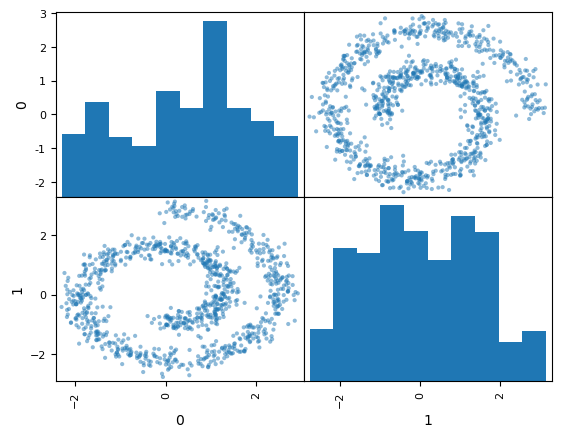

In [7]:
# check the dataset
dataset = args.data
dataset = 'swissroll'
# dataset = 'swissroll_6D_xy1'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)

## Initialize Data using CIFAR-10


In [8]:
# check the dataset
dataset = args.data
dataset = 'cifar10'
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)
data_dim = means.shape[1]
# dataset = 'swissroll_6D_xy1'
""""" # not used anymore since our data is pictures
means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)
data_dim = means.shape[1]
print('data_dim',data_dim)

blah = pd.DataFrame(means)
pdsm(blah)
"""


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_7760\310266888.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32)


'"" # not used anymore since our data is pictures\nmeans  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 1000)).to(dtype = torch.float32)\ndata_dim = means.shape[1]\nprint(\'data_dim\',data_dim)\n\nblah = pd.DataFrame(means)\npdsm(blah)\n'

In [ ]:
depth = args.depth
hidden_units = args.hiddenunits
factornet = construct_factor_model(data_dim, depth, hidden_units).to(device).to(dtype = torch.float32)

lr = args.lr
optimizer = optim.Adam(factornet.parameters(), lr=args.lr)

p_samples = toy_data.inf_train_gen(dataset,batch_size = train_samples_size)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)
centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)

# torch.save(centers, save_directory + 'centers.pt')

epochs = args.niters
batch_size = args.batch_size

# Training the score network
loss = evaluate_model(factornet, centers, test_samples_size)
formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'Before train, Average total_loss: {formatted_loss}')

tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_7760\3618843182.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_samples = torch.tensor(p_samples).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)


C:\Users\pongd\AppData\Local\Temp\ipykernel_7760\3618843182.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers  = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = train_kernel_size)).to(dtype = torch.float32).to(device)


tensor(-1.) tensor(1.)


In [ ]:
for step in range(epochs):
    # samples_toydata
    randind = torch.randint(0,train_samples_size,[batch_size,])
    samples = training_samples[randind,:]

    loss = LearnCholesky.score_implicit_matching(factornet,samples,centers)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if not step % 4000:
        loss_value = loss.item()
        print(f'Step: {step}, Loss value: {loss_value:.3e}')

    if not step % 20000:
        loss0 = evaluate_model(factornet, centers, test_samples_size)
        save_training_slice_cov(factornet, centers, step, lr, batch_size, loss0, save_directory)

formatted_loss = f'{loss:.3e}'  # Format the average with up to 1e-3 precision
print(f'After train, Average total_loss: {formatted_loss}')

Step: 0, Loss value: -7.223e-02
Step: 4000, Loss value: -2.318e+01
Step: 8000, Loss value: -1.940e+01
Step: 12000, Loss value: -2.402e+01
Step: 16000, Loss value: -2.512e+01
Step: 20000, Loss value: -1.015e+01
Step: 24000, Loss value: -2.714e+01
Step: 28000, Loss value: -2.765e+01
Step: 32000, Loss value: -2.619e+01
Step: 36000, Loss value: -1.371e+01
Step: 40000, Loss value: -1.837e+01
Step: 44000, Loss value: -2.327e+01
Step: 48000, Loss value: -9.906e+00
After train, Average total_loss: -2.057e+01


In [ ]:
# sample from trained model
# and plot density
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)
LearnCholesky.plot_images(centers, precisions,plot_number=10,save_path=save_directory + 'samples.png')

""" I think this will not work for general (centers needs to be same as before to plot properly)
randind = torch.randint(0,1000,[1000,])
centers = means[randind,:].to(device)
precisions = LearnCholesky.vectors_to_precision(factornet(centers),data_dim)

LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 0, dim2 = 1,save_path=save_directory + 'samples.png')
LearnCholesky.plot_density_2d_marg(centers,factornet,dim1 = 0, dim2 = 1, save_path=save_directory + 'density.png')
"""

NameError: name 'LearnCholesky' is not defined

In [ ]:
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 2, dim2 = 3, save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 2, dim2 = 3, save_path=save_directory + 'density.png')
# LearnCholesky.scatter_samples_from_model(centers, precisions, dim1 = 4, dim2 = 5,  save_path=save_directory + 'samples.png')
# LearnCholesky.plot_density_2d_marg(centers,factornet, dim1 = 4, dim2 = 5,save_path=save_directory + 'density.png')